In [56]:
# Gerekli kütüphaneler
import librosa
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import warnings        
warnings.filterwarnings("ignore")

In [57]:
def read_and_sample(csv_path, fraction):
    data = pd.read_csv(csv_path)
    sample_data = data.sample(frac=fraction, random_state=42)
    return sample_data

In [58]:
# Verileri oku
sample_fraction = 0.5

train_data = read_and_sample("Datasets/train.csv", sample_fraction)
val_data = read_and_sample("Datasets/val.csv", sample_fraction)
test_data = read_and_sample("Datasets/test.csv", sample_fraction)

In [59]:
# Kontrol et
print("Train Data Sample:")
print(train_data.head())
print("Validation Data Sample:")
print(val_data.head())
print("Test Data Sample:")
print(test_data.head())

Train Data Sample:
                                                features  labels
11456  Datasets\zh-CN\clips\common_voice_zh-CN_189554...       1
1288   Datasets\zh-CN\clips\common_voice_zh-CN_188230...       1
5535   Datasets\zh-CN\clips\common_voice_zh-CN_189779...       1
12657  Datasets\zh-CN\clips\common_voice_zh-CN_190086...       1
8603      Datasets\tr\clips\common_voice_tr_17527179.mp3       0
Validation Data Sample:
                                               features  labels
1652  Datasets\zh-CN\clips\common_voice_zh-CN_189997...       1
5303  Datasets\zh-CN\clips\common_voice_zh-CN_189834...       1
2987  Datasets\zh-CN\clips\common_voice_zh-CN_198784...       1
1545     Datasets\tr\clips\common_voice_tr_17529087.mp3       0
3767  Datasets\zh-CN\clips\common_voice_zh-CN_186595...       1
Test Data Sample:
                                               features  labels
1057     Datasets\tr\clips\common_voice_tr_17483907.mp3       0
812      Datasets\tr\clips\common_voi

In [60]:
# Etiket dönüşüm fonksiyonu
def labels(label):
    return tf.constant([1, 0] if label == 0 else [0, 1], dtype=tf.int32)

In [61]:
# train verileri yükle
train_x_list, train_y_list = [], []

for index, row in train_data.iterrows():
    audio, sample_rate = librosa.load(row['features'])
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate)
    tensor_x = tf.transpose(tf.convert_to_tensor(mfccs, dtype=tf.float32))
    tensor_y = labels(row['labels'])
    train_x_list.append(tensor_x)
    train_y_list.append(tensor_y)

In [62]:
# val verileri yükle
val_x_list, val_y_list = [], []

for index, row in val_data.iterrows():
    audio, sample_rate = librosa.load(row['features'])
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate)
    tensor_x = tf.transpose(tf.convert_to_tensor(mfccs, dtype=tf.float32))
    tensor_y = labels(row['labels'])
    val_x_list.append(tensor_x)
    val_y_list.append(tensor_y)

In [64]:
# Parametreleri ayarla
batch_size = 64
epochs = 100
input_size = 20
hidden_size = 256
output_size = 2
learning_rate = 1e-4

In [65]:
# train_dataset oluştur
def generator_train():
    for features, labels in zip(train_x_list, train_y_list):
        yield (features, labels)

train_dataset = tf.data.Dataset.from_generator(
    generator_train,
    output_types=(tf.float32, tf.int32),
    output_shapes=((None, input_size), (output_size))
)

train_dataset = train_dataset.padded_batch(batch_size=batch_size, padded_shapes=([None, input_size], [output_size]))

In [66]:
# val_dataset oluştur
def generator_val():
    for features, labels in zip(val_x_list, val_y_list):
        yield (features, labels)
        
val_dataset = tf.data.Dataset.from_generator(
    generator_val,
    output_types=(tf.float32, tf.int32),
    output_shapes=((None, input_size), (output_size))
)

val_dataset = val_dataset.padded_batch(batch_size=batch_size, padded_shapes=([None, input_size], [2]))

In [67]:
# Modeli oluştur
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, input_size), batch_size=batch_size),
    tf.keras.layers.LSTM(hidden_size,kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
    tf.keras.layers.Dense(output_size, activation='linear',kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))
])

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (64, 128)              │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (64, 2)                │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,546 (299.01 KB)

 Trainable params: 76,546 (299.01 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Modeli eğit
checkpoint_path = "Checkpoints/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_dataset,  
          epochs=10,
          validation_data=val_dataset,
          callbacks=[cp_callback])

Epoch 1/10
      4/Unknown 1s 276ms/step - accuracy: 0.6155 - loss: 1.0563
Epoch 1: saving model to Checkpoints/cp.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step - accuracy: 0.6139 - loss: 1.0559 - val_accuracy: 0.5909 - val_loss: 1.0557
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6155 - loss: 1.0490
Epoch 2: saving model to Checkpoints/cp.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step - accuracy: 0.6139 - loss: 1.0487 - val_accuracy: 0.5909 - val_loss: 1.0490
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6155 - loss: 1.0419
Epoch 3: saving model to Checkpoints/cp.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 380ms/step - accuracy: 0.6139 - loss: 1.0416 - val_accuracy: 0.5909 - val_loss: 1.0424
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6155 - loss: 1.0348
Epoch 4: saving model to Checkpoints/cp.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.6139 - loss: 1.0346 - val_accuracy: 0.5909 - val_loss: 1.0358
Epoch 5/1

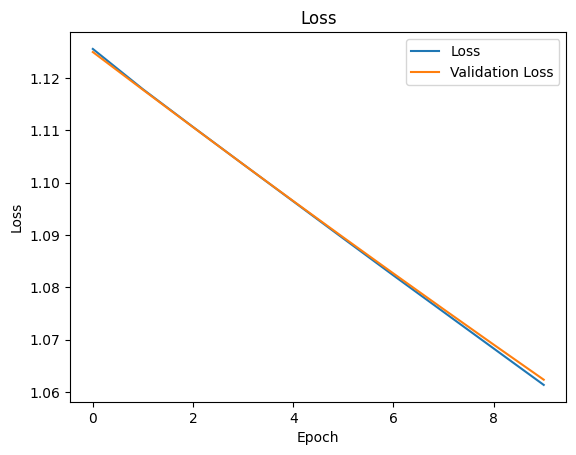

In [70]:
# Loss grafiği çizdir
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(1, 1)

ax.plot(loss, label='Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

In [71]:
# Validation Accuracy grafiği çizdir
val_acc = history.history['val_accuracy']

ax.plot(val_acc, label='Validation Accuracy')
ax.set_title('Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

plt.show()

In [72]:
# test verileri yükle
test_x_list, test_y_list = [], []

for index, row in test_data.iterrows():
    audio, sample_rate = librosa.load(row['features'])
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate)
    tensor_x = tf.transpose(tf.convert_to_tensor(mfccs, dtype=tf.float32))
    tensor_y = labels(row['labels'])
    test_x_list.append(tensor_x)
    test_y_list.append(tensor_y)

In [73]:
# test_dataset oluştur
def generator_test():
    for features, labels in zip(test_x_list, test_y_list):
        yield (features, labels)

test_dataset = tf.data.Dataset.from_generator(
    generator_test,
    output_types=(tf.float32, tf.int16),
    output_shapes=((None, input_size), (output_size))
)

test_dataset = test_dataset.padded_batch(batch_size=batch_size, padded_shapes=([None, input_size], [output_size]))

In [74]:
loss, acc = model.evaluate(test_dataset, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

1/1 - 1s - 539ms/step - accuracy: 0.5152 - loss: 1.0657
Untrained model, accuracy: 51.52%
